In [1]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext
!pip install emoji==1.7
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 372.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=9628e70373553b0c8eea689b1aa2a2ef58eecbd97574164de38363f07ffc8aa8
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.1.0
    Uninstalling emoji-2.1.0:
      Successfully uninstalled emoji-2.1.0
  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a4f3f87da2ee7fd45751e12b4865e0ed7c00db7878eba8ad2b70034a989804df
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle
from sklearn.decomposition import PCA
# call backs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-12-03 08:15:35.494044: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 08:15:35.494083: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-03 08:15:35.545604: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-03 08:15:35.588475: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 08:15:35.588668: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Benchmark Datasets

**_There are different datasets that have been used in different studies, which can help benchmark the performance of our approach under different real world stress factors such as, small/large sample sizes, limited outcome category size, and diverse field of application._**

Here the proposed aproach will be tried on these datasets to see how the performance changes. The same steps we used on the main data will here be used to avoid influencing the performance.

## 1) Fake News dataset

The data is a small sample of 6256 news articles with half being unreliable and the other half reliable (AMIN, 2019). The motivation behind including the data in this study is to understand the ability of the proposed algorithm to learn from small samples.

In [3]:

batch_size=64  #  Batch sizes to use
epoch =200     # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

In [4]:
Bench1= pd.read_csv("../input/textdb3/fake_or_real_news.csv") # loading data
#Bench1=Bench1.sample(n=10000)                                  # sampling a small piece of the data
Bench1['Index']=range(0,Bench1.shape[0])                      # rearranging indices
Bench1=Bench1.set_index('Index')

Labels were converted into two categories,`fake` and `realible`

In [5]:
# converting labels to binary

def to_binary_labels(labels):
    if labels =="REAL":
        x="reliable"
    else:
        x="fake" 
    return x

Bench1['label']=pd.Series (list(map(to_binary_labels,Bench1['label'])))

The bar graph here shows the distribution of articles across the two groups

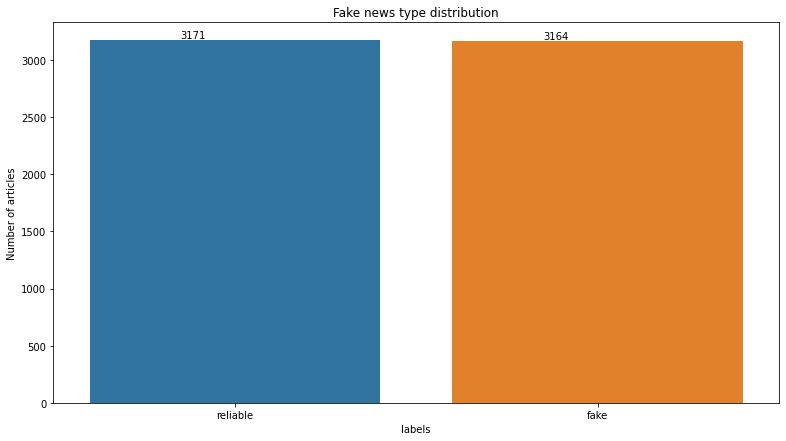

In [6]:
# visualizing labels 

figure,ax=plt.subplots(nrows=1,ncols=1,figsize=(13,7))
sns.countplot(x='label',data=Bench1,ax=ax,order=Bench1.groupby('label').size().sort_values().index[::-1])
for p, label in zip(ax.patches, Bench1['label'].value_counts().index):
    ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax.set_xlabel("labels")
    ax.set_ylabel("Number of articles")
    ax.set_title('Fake news type distribution')
plt.savefig('Distribution1.png')

Just on the main data, title and the body of the articles features on different columns, here we iterate over each article and join the title and the body.

In [7]:
# joining the titles  with  

text1=[]
for i in range(Bench1.shape[0]):
    if pd.isnull(Bench1['title'][i]) or pd.isna(Bench1['title'][i]):
        if pd.isnull(Bench1['text'][i]) or pd.isna(Bench1['text'][i]):
            x=""
        else:
            x=str(Bench1['text'][i])
    else: 
        if pd.isnull(Bench1['text'][i]) or pd.isna(Bench1['text'][i]):
            x=str(Bench1['title'][i])
        else:
            x=str(Bench1['title'][i])+"\n"+str(Bench1['text'][i])
    text1.append(x)
Bench1['text1']=pd.Series (text1)

Here emojis and emocations were removed.

In [8]:
# remove emojis
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

In [9]:
Bench1['text1']=Bench1['text1'].apply(remove_emoji)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


here unicodes characters were replaced by looking up from a table(like we on the original data.)

In [10]:
text1=[]
for j in range(Bench1.shape[0]):
    text1.append(Bench1["text1"][j].replace("’","'"))
Bench1["text1"]=pd.Series (text1)

In [11]:
# here we are getting the table to python in order to do the replacement.

strange=pd.read_html(requests.get('https://lhncbc.nlm.nih.gov/LSG/Projects/lvg/current/docs/designDoc/UDF/unicode/DefaultTables/symbolTable.html').content)[-1] #getting the webpage with the table

strange=strange.append(pd.DataFrame({'Unicode':["U+302D"],      #  cast the table into a dataframe
              'Mapped String':["..."],
              "Char":["…"],
              'Unicode Name':["THREE DOTS"]}),ignore_index=True) 
s_n=len(strange)
strange=strange.drop(list(strange["Mapped String"]).index("'"))

In [12]:
for j in range(Bench1.shape[0]):
    for i in [x for x in range(s_n) if x != 2]:
        Bench1["text1"][j]=Bench1["text1"][j].replace(strange["Char"][i],str(strange["Mapped String"][i]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


On the next column we removed extra white space and converted words to lowercase.

In [13]:
def my_clean(text):
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=False , # Stem the words
                           stopwords=False ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=False ,# Remove all digits 
                           punct=False ,# Remove all punctuations
                           reg= "", # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x

def my_clean1(text): 
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=True , # Stem the words
                           stopwords=True ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=True ,# Remove all digits 
                           punct=True ,# Remove all punctuations
                           reg= '\n', # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x

In [14]:
Bench1['article']=Bench1['text1'].apply(my_clean)

Next the labels were converted into two class dummy variables because neural networks won't allow character strings.This means because we have two classes, in this order fake,reliable. label [1 0] would mean fake while [0 1] would mean reliable. Here is a example using the first row.

In [15]:
texts=Bench1['article'].apply(my_clean1)
leb=pd.get_dummies(Bench1['label']).values
print(leb[0],Bench1['label'][0])

[1 0] fake


The data was then split into 80% training set, 15% testing and 5% validation sets. The training set, will be used to train the model, testing will be used to test the model while validation will be used for validation purposes.

In [16]:
random.seed(100)
train_ind=random.sample(range(len(Bench1)), k=round(len(Bench1) * 0.8))
test_valid_ind=list(set(range(len(Bench1))).difference(train_ind))

test_ind=random.sample(test_valid_ind,k=round(len(test_valid_ind) * 0.75))
valid_ind=list(set(test_valid_ind).difference(test_ind))

train=Bench1.iloc[train_ind,]
test=Bench1.iloc[test_ind,]
valid=Bench1.iloc[valid_ind,]

In [17]:
print("---------training breakdown-----------")
print()
print(train.label.value_counts())
print()
print("---------testing breakdown-----------")
print()
print(test.label.value_counts())
print()
print("---------validation breakdown-------")
print(valid.label.value_counts())

---------training breakdown-----------

reliable    2552
fake        2516
Name: label, dtype: int64

---------testing breakdown-----------

fake        492
reliable    458
Name: label, dtype: int64

---------validation breakdown-------
reliable    161
fake        156
Name: label, dtype: int64


converting the data into tensorflow dataset to take advantage of these features.

In [18]:
train = tf.data.Dataset.from_tensor_slices((list(train["article"]),list(leb[train_ind])))
test = tf.data.Dataset.from_tensor_slices((list(test["article"]),list(leb[test_ind])))
valid = tf.data.Dataset.from_tensor_slices((list(valid["article"]),list(leb[valid_ind])))

2022-12-03 08:23:15.979910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 08:23:16.068458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 08:23:16.069259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 08:23:16.072210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
train= train.batch(batch_size=batch_size)
test= test.batch(batch_size=batch_size)
valid= valid.batch(batch_size=batch_size)

In [20]:
tf.data.experimental.save(train, "fakenewstrain")
tf.data.experimental.save(test, "fakenewstest")
tf.data.experimental.save(valid, "fakenewsvalid")

2022-12-03 08:23:18.994028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [21]:
print("training batches :",len(train))
print("test batches :",len(test))
print("valid batches :",len(valid))

training batches : 80
test batches : 15
valid batches : 5


The dataset was batched into batches of 64 articles to enable faster processing and model fitting.

In [22]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)

In [23]:
def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Text vectorizaton.It shows how the first article can be vectorized, into integers.

In [24]:
article,label= next(iter(train))
sample_article,sample_label = article[1],label[1]
print("Article:")
print(sample_article)
lb=["Reliable","Fake"]
print("Label:")
print(sample_label)
print("After vectorization:")
print(vectorize_articles(sample_article,sample_label))

Article:
tf.Tensor(b'the gop\'s pathetic scotus games: why its merrick garland obstruction just got even more embarrassing\na few weeks ago, sen. chuck grassley was travelling around his home state of iowa with his fingers jammed deep in his ears while yelling "la la la la la i can\'t hear you" to any constituents who wanted to voice a negative opinion about his role in refusing to hold confirmation hearings for merrick garland, president obama\'s nominee to replace the recently deceased antonin scalia on the supreme court. that\'s some constituent service he\'s running from his iowa offices! maybe he should save some money by closing the offices and just tattooing the words "blow me" on his forehead like an old white version of bill o\'reilly\'s worst\xc2\xa0nightmares.\n\ndespite his efforts to wall himself off from criticism, grassley did hear some negative reactions from his constituents during his town halls. perhaps mindful of the fact that he\'s up for re-election in november in

2022-12-03 08:23:20.741481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [25]:
vocabularies = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabularies, range(len(vocabularies))))

More performance configuration including caching and prefetching.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)

get embeddings

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-03 08:23:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-03 08:23:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-03 08:23:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [28]:
embeddings_index = {}
with open("/kaggle/working/glove.6B.100d.txt") as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_dim=100
hits = 0
misses = 0

# Prepare embedding matrix
embed_mat = np.zeros((max_tokens + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embed_mat[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18964 words (1036 misses)


In [30]:
model1=Sequential(name="my_model")
model1.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model1.add(Embedding(max_tokens + 1,
                    embedding_dim,embeddings_initializer=keras.initializers.Constant(embed_mat),
                    trainable=False,
                    name="embeddinglayer"))
model1.add(Dropout(0.2,name="dropout"))
model1.add(layers.Conv1D(8,5, activation='relu'))
model1.add(Dropout(0.2,name="dropout1"))
model1.add(BatchNormalization(name="batchnormalization"))
model1.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model1.add(Dropout(0.2,name="dropout2"))
model1.add(Dense(units=8,activation="relu"))
model1.add(Dropout(0.2,name="dropout3"))
model1.add(Dense(units=2, activation="softmax"))

Fitting our model on the new data. the same specification as on the odd model were used.

In [31]:
#from IPython.display import YouTubeVideo
#YouTubeVideo('hjx-zwVdfjc', width=800, height=450)

Model compilation

In [32]:
model1.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

fitting the model

In [33]:
mod=model1.fit(
 train,
  validation_data=test,
 epochs=epoch,
    callbacks=[es_callback,tensorboard_callback])

Epoch 1/200


2022-12-03 08:26:40.060667: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/80 [..............................] - ETA: 14:15 - loss: 0.7106 - accuracy: 0.5312 - Sensitivity: 0.6333 - Specificity: 0.4412 - Precision: 0.5000 - f1_score: 0.5312

2022-12-03 08:26:46.235871: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 08:26:46.235916: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/80 [..............................] - ETA: 1:06 - loss: 0.6940 - accuracy: 0.5391 - Sensitivity: 0.5690 - Specificity: 0.5143 - Precision: 0.4925 - f1_score: 0.5391 

2022-12-03 08:26:46.983387: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 08:26:47.004317: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 08:26:47.141066: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 30272 callback api events and 30240 activity events. 
2022-12-03 08:26:47.478384: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 08:26:48.067419: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_08_26_47

2022-12-03 08:26:48.419192: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_12_03_08_26_47/c01b5821b708.trace.json.gz
2022-12-03 08:26:48.738609: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/

80/80 [==============================] - 42s 399ms/step - loss: 0.6937 - accuracy: 0.5286 - Sensitivity: 0.6089 - Specificity: 0.4495 - Precision: 0.5216 - f1_score: 0.5286 - val_loss: 0.6794 - val_accuracy: 0.6611 - val_Sensitivity: 0.7337 - val_Specificity: 0.5830 - val_Precision: 0.6540 - val_f1_score: 0.6611
Epoch 2/200
80/80 [==============================] - 29s 358ms/step - loss: 0.6498 - accuracy: 0.6235 - Sensitivity: 0.6510 - Specificity: 0.5964 - Precision: 0.6139 - f1_score: 0.6235 - val_loss: 0.5950 - val_accuracy: 0.7168 - val_Sensitivity: 0.6565 - val_Specificity: 0.7817 - val_Precision: 0.7636 - val_f1_score: 0.7168
Epoch 3/200
80/80 [==============================] - 26s 329ms/step - loss: 0.5865 - accuracy: 0.6973 - Sensitivity: 0.7595 - Specificity: 0.6360 - Precision: 0.6729 - f1_score: 0.6973 - val_loss: 0.5113 - val_accuracy: 0.7442 - val_Sensitivity: 0.6118 - val_Specificity: 0.8865 - val_Precision: 0.8527 - val_f1_score: 0.7442
Epoch 4/200
80/80 [===============

In [34]:
model1.save("model1") 
with open("mod1_hist.pkl","wb") as file:
    pickle.dump(mod.history,file)

2022-12-03 09:24:13.562157: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Graphing accuracy on both training and testing set.on each epoch.

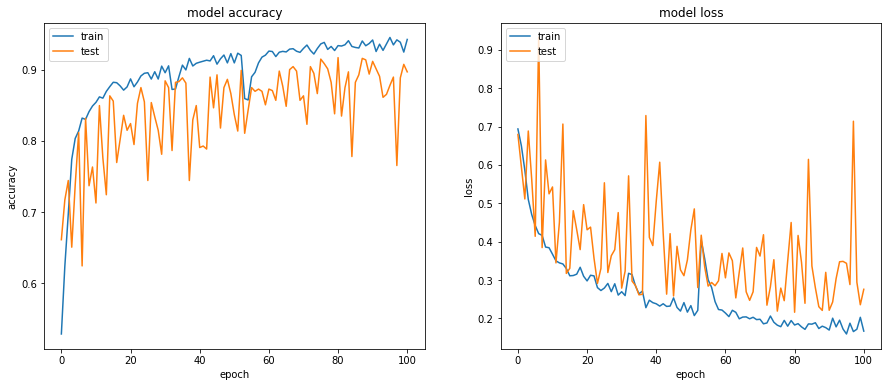

In [35]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod.history['loss'])
ax[1].plot(mod.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing1.png')

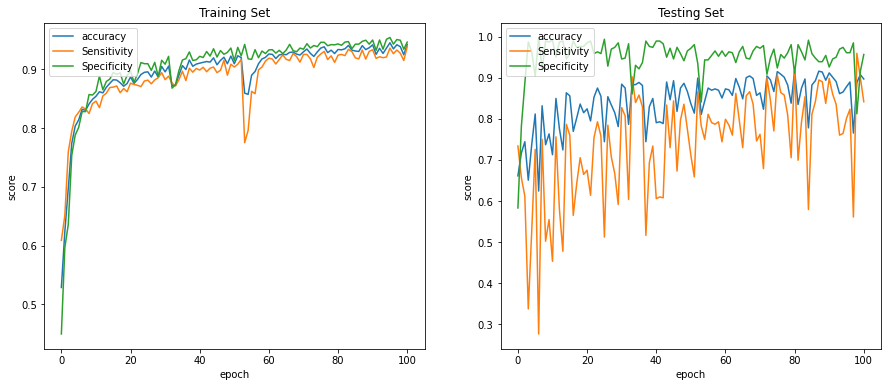

In [36]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod.history['val_accuracy'])
ax[1].plot(mod.history['val_Sensitivity'])
ax[1].plot(mod.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['Sensitivity'])
ax[0].plot(mod.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing2.png')

Evaluating the model on the testing set.

In [37]:
mod2=model1.evaluate(test)[1:6]
mod2=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod2]})
mod2

15/15 [==============================] - 3s 136ms/step - loss: 0.2759 - accuracy: 0.8968 - Sensitivity: 0.8415 - Specificity: 0.9563 - Precision: 0.9539 - f1_score: 0.8968


,Measure,Original Dataset
0,Accuracy,0.8968
1,Sensitivity,0.8415
2,Specificty,0.9563
3,Precision,0.9539
4,F1 score,0.8968


Fitting a Kmeans clustering

In [38]:
# feature extraction model
feature_miner=Model(
    inputs=model1.inputs,
    outputs=model1.get_layer(name="Bidirectional2").output,name="feature_miner"
)

In [39]:
predictors=feature_miner.predict(train)
kmea=KMeans(n_clusters=2, random_state=0).fit(predictors)
tests=feature_miner.predict(test)
kmeans_pred=kmea.predict(tests)
kmea.labels_

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [40]:
with open("predictors1.pkl","wb") as file:
    pickle.dump(predictors,file)
    
with open("tests1.pkl","wb") as file:
    pickle.dump(tests,file)
    
with open("kmea1.pkl","wb") as file:
    pickle.dump(kmea,file)

converting labels to 1 column instead of array

In [41]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

An important thing to notice is,the Kmeans labels  0,1 represent clusters 0 and 1 but not the data labels 0,1. the code here tries to determine which category  exacltly matches which cluster.

In [42]:
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.9063157894736842
0.09368421052631579


In [43]:
kmeans_pred1=kmeans_pred
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

Evaluating the Kmeans clustering

In [44]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             'Benchmark 1':[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})

,Measure,Benchmark 1
0,Accuracy,0.906316
1,Sensitivity,0.873984
2,Specitivity,0.941048
3,Precision,0.940919
4,F1 score,0.906217


Final prediction whiles weighting the to models.

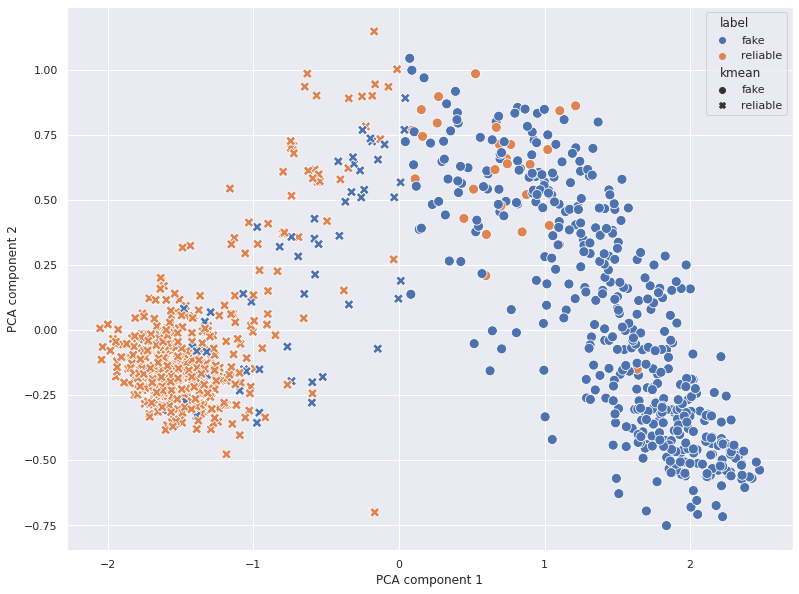

In [45]:
pca = PCA(2)
pcas= pd.DataFrame(pca.fit_transform(tests), columns = ['x','y'])
pcas['kmean']= kmeans_pred
pcas['label']= label_test

def to_binary_labels(labels):
    if labels ==0:
        x="fake"
    else:
        x= "reliable" 
    return x

pcas['label']=pd.Series (list(map(to_binary_labels,pcas['label'])))
pcas['kmean']=pd.Series (list(map(to_binary_labels,pcas['kmean'])))
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.scatterplot(data=pcas, x="x", y="y",s=100,style="kmean",hue='label')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.savefig('PCA1.png')

In [46]:
modelpred=np.argmax(model1.predict(test), axis=1)
sensdeep=metrics.recall_score(label_test, modelpred,pos_label=0)
senskmeans=metrics.recall_score(label_test,kmeans_pred,pos_label=0)
specdeep=metrics.recall_score(label_test, modelpred,pos_label=1)
speckmean=metrics.recall_score(label_test,kmeans_pred,pos_label=1)
def weighting(kmeans_pred,modelpred):
    conditionals= [] 
    unconditionals=[]
    types= [] 
    for i in range(len(kmeans_pred)):
        if modelpred[i]==0 and kmeans_pred[i]==0:
            x=[sensdeep*senskmeans,(1-specdeep)*(1-speckmean)]
        elif modelpred[i]==1 and kmeans_pred[i]==1:
            x=[(1-sensdeep)*(1-senskmeans),specdeep*speckmean]
        elif modelpred[i]==0 and kmeans_pred[i]==1:
            x=[sensdeep*(1-senskmeans),(1-specdeep)*speckmean]
        else:
            x=[(1-sensdeep)*senskmeans,specdeep*(1-speckmean)]
        conditionals.append(x)
        unconditionals.append((np.array(x)/sum(x)).tolist())
    preds=np.argmax(unconditionals,axis=1)
    return preds
preds=weighting(modelpred,kmeans_pred)

In [47]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.908421
1,Sensitivity,0.878049
2,Specitivity,0.941048
3,Precision,0.941176
4,F1 score,0.908517


**Validation**

In [48]:
modelpred=np.argmax(model1.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

preds=weighting(modelpred,kmeans_pred)

In [49]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.927445
1,Sensitivity,0.903846
2,Specitivity,0.950311
3,Precision,0.946309
4,F1 score,0.924590


# 2) Authentic and Inauthentic dataset
 
 The dataset involves of 23,481 real world news articles collected from Reuters.com website and 21,417 unreliable news articles collected from Kaggle.com, during the years 2016 and 2017. The data focused on only political news articles with at least 200 characters (Ahmed et al., 2017). The choice of this benchmark data was influenced by the fact it covers several years.  The data can be used to understand the rate of in accuracy over time, attributable to mutation in vocabulary use

load data

In [50]:
Bench2_1= pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
Bench2_1['label']='fake'
Bench2_2= pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
Bench2_2['label']='reliable'
Bench2=pd.concat([Bench2_1, Bench2_2], axis = 0,ignore_index=True)
#Bench2=Bench2.sample(n=10000)
Bench2['Index']=range(0,Bench2.shape[0])
Bench2=Bench2.set_index('Index')

Graph labels to show distribution of articles.across the two classes

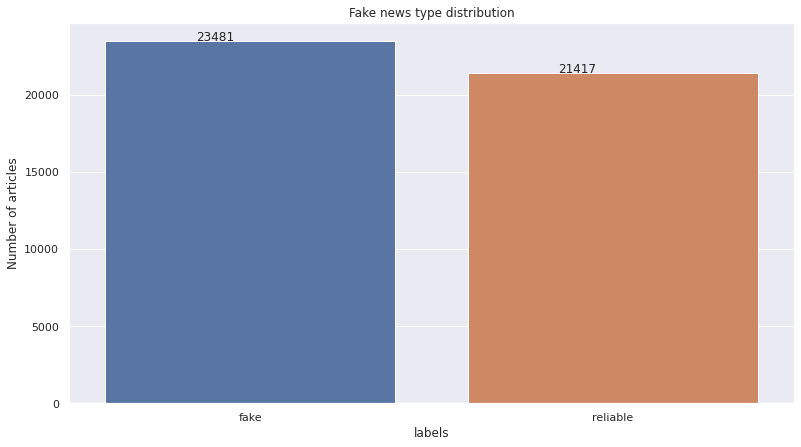

In [51]:
figure,ax=plt.subplots(nrows=1,ncols=1,figsize=(13,7))
sns.countplot(x='label',data=Bench2,ax=ax,order=Bench2.groupby('label').size().sort_values().index[::-1])
for p, label in zip(ax.patches, Bench2['label'].value_counts().index):
    ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax.set_xlabel("labels")
    ax.set_ylabel("Number of articles")
    ax.set_title('Fake news type distribution')
    

plt.savefig('fakenewsdist.png')

In [52]:
Bench2.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Join title with the article body to process together

In [53]:
11272+6841

18113

In [54]:
text1=[]
for i in range(Bench2.shape[0]):
    if pd.isnull(Bench2['title'][i]) or pd.isna(Bench2['title'][i]):
        if pd.isnull(Bench2['text'][i]) or pd.isna(Bench2['text'][i]):
            x=""
        else:
            x=str(Bench2['text'][i])
    else: 
        if pd.isnull(Bench2['text'][i]) or pd.isna(Bench2['text'][i]):
            x=str(Bench2['title'][i])
        else:
            x=str(Bench2['title'][i])+"\n"+str(Bench2['text'][i])
    text1.append(x)
Bench2['text1']=pd.Series (text1)

remove emojis and emocations

In [55]:
# remove emojis and emocations
Bench2['text1']=Bench2['text1'].apply(remove_emoji)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


here unicodes characters were replaced by looking up from a table(like we on the original data.

In [56]:
text1=[]
for j in range(Bench2.shape[0]):
    text1.append(Bench2["text1"][j].replace("’","'"))
Bench2["text1"]=pd.Series (text1)

In [57]:
for j in range(Bench2.shape[0]):
    for i in [x for x in range(s_n) if x != 2]:
        Bench2["text1"][j]=Bench2["text1"][j].replace(strange["Char"][i],str(strange["Mapped String"][i]))

Next the labels were converted into two class dummy variables because neural networks won't allow character strings.This means because we have two classes, in this order fake,reliable. label [1 0] would mean fake while [0 1] would mean reliable. Here is a example using the first row.

In [58]:
Bench2['article']=Bench2['text1'].apply(my_clean)
texts=Bench2['article'].apply(my_clean1)

In [59]:
leb=pd.get_dummies(Bench2['label']).values
print(leb[0],Bench2['label'][0])
print(leb[44893],Bench2['label'][44893])

[1 0] fake
[0 1] reliable


The data was then split into 80% training set, 15% testing and 5% validation sets. The training set, will be used to train the model, testing will be used to test the model while validation will be used for validation purposes.

In [60]:
random.seed(100)
train_ind=random.sample(range(len(Bench2)), k=round(len(Bench2) * 0.8))
test_valid_ind=list(set(range(len(Bench2))).difference(train_ind))

test_ind=random.sample(test_valid_ind,k=round(len(test_valid_ind) * 0.75))
valid_ind=list(set(test_valid_ind).difference(test_ind))

train=Bench2.iloc[train_ind,]
test=Bench2.iloc[test_ind,]
valid=Bench2.iloc[valid_ind,]

In [61]:
print("---------training breakdown-----------")
print()
print(train.label.value_counts())
print()
print("---------testing breakdown-----------")
print()
print(test.label.value_counts())
print()
print("---------validation breakdown-------")
print(valid.label.value_counts())

---------training breakdown-----------

fake        18816
reliable    17102
Name: label, dtype: int64

---------testing breakdown-----------

fake        3515
reliable    3220
Name: label, dtype: int64

---------validation breakdown-------
fake        1150
reliable    1095
Name: label, dtype: int64


converting the data into tensorflow dataset to take advantage of these features.

In [62]:
train = tf.data.Dataset.from_tensor_slices((list(train["article"]),list(leb[train_ind])))
test = tf.data.Dataset.from_tensor_slices((list(test["article"]),list(leb[test_ind])))
valid = tf.data.Dataset.from_tensor_slices((list(valid["article"]),list(leb[valid_ind])))

In [63]:
train= train.batch(batch_size=batch_size)
test= test.batch(batch_size=batch_size)
valid= valid.batch(batch_size=batch_size)

In [64]:
tf.data.experimental.save(train, "authenticewstrain")
tf.data.experimental.save(test, "authenticnewstest")
tf.data.experimental.save(valid, "authenticnewsvalid")

In [65]:
print("training batches :",len(train))
print("test batches :",len(test))
print("valid batches :",len(valid))

training batches : 562
test batches : 106
valid batches : 36


In [66]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)

In [67]:
vocabularies = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabularies, range(len(vocabularies))))

Text vectorizaton.It shows how the first article can be vectorized, into integers.

In [68]:
article,label= next(iter(train))
sample_article,sample_label = article[0],label[0]
print("Article:")
print(sample_article)
lb=["Reliable","Fake"]
print("Label:")
print(sample_label)
print("After vectorization:")
print(vectorize_articles(sample_article,sample_label))

Article:
tf.Tensor(b"lawyer for fbi informant knows of russian bribery and info 'that involves the clintons' [video]\ndc lawyer victoria toensing is one smart cookie. she s representing a former fbi informant who has evidence on kickbacks and bribery involving the transportation of uranium in the us. she recently told sean hannity her client will brief congress about russian involvement in the u.s. uranium market. this includes widespread bribery and actions that involved the clintons i m not going into detail, attorney victoria toensing said on the oct. 24 hannity. you know that, sean. but the informant will give an overview and specific conversations that he had with russians in what they were thinking about the money that they were spending. i mean, let me just be that general and it involves the clintons. the director of the fbi at that time was robert mueller, and he is now the special counsel investigating alleged russian collusion with the 2016 trump campaign. the undercover inv

2022-12-03 10:32:24.925504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


More performance configuration including caching and prefetching.

In [69]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
embedding_dim=100
hits = 0
misses = 0

# Prepare embedding matrix
embed_mat = np.zeros((max_tokens + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embed_mat[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18830 words (1170 misses)


Fitting our model on the new data. the same specification as on the odd model were used.

In [71]:
model2=Sequential(name="my_model")
model2.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model2.add(Embedding(max_tokens + 1,
                    embedding_dim,embeddings_initializer=keras.initializers.Constant(embed_mat),
                    trainable=False,
                    name="embeddinglayer"))
model2.add(Dropout(0.2,name="dropout"))
model2.add(layers.Conv1D(8,5, activation='relu'))
model2.add(Dropout(0.2,name="dropout1"))
model2.add(BatchNormalization(name="batchnormalization"))
model2.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model2.add(Dropout(0.2,name="dropout2"))
model2.add(Dense(units=8,activation="relu"))
model2.add(Dropout(0.2,name="dropout3"))
model2.add(Dense(units=2, activation="softmax"))

Compiling the model

In [72]:
model2.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

Model fitting

In [73]:
mod=model2.fit(
 train,
  validation_data=test,
 epochs=epoch,
    callbacks=[es_callback,tensorboard_callback])

Epoch 1/200
  1/562 [..............................] - ETA: 34:12 - loss: 0.7409 - accuracy: 0.4688 - Sensitivity: 0.0909 - Specificity: 0.8710 - Precision: 0.4286 - f1_score: 0.4688

2022-12-03 10:32:41.590507: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 10:32:41.590552: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/562 [..............................] - ETA: 4:47 - loss: 0.7270 - accuracy: 0.4609 - Sensitivity: 0.1231 - Specificity: 0.8095 - Precision: 0.4000 - f1_score: 0.4609 

2022-12-03 10:32:42.232916: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 10:32:42.240974: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 10:32:42.378680: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 8251 callback api events and 8219 activity events. 
2022-12-03 10:32:42.480159: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 10:32:42.647599: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_10_32_42

2022-12-03 10:32:42.755148: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_12_03_10_32_42/c01b5821b708.trace.json.gz
2022-12-03 10:32:42.859009: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/tr

562/562 [==============================] - 96s 164ms/step - loss: 0.2105 - accuracy: 0.9109 - Sensitivity: 0.9199 - Specificity: 0.9010 - Precision: 0.9109 - f1_score: 0.9109 - val_loss: 0.0250 - val_accuracy: 0.9936 - val_Sensitivity: 0.9983 - val_Specificity: 0.9885 - val_Precision: 0.9896 - val_f1_score: 0.9936
Epoch 2/200
562/562 [==============================] - 83s 147ms/step - loss: 0.0472 - accuracy: 0.9899 - Sensitivity: 0.9910 - Specificity: 0.9888 - Precision: 0.9899 - f1_score: 0.9899 - val_loss: 0.0172 - val_accuracy: 0.9961 - val_Sensitivity: 0.9983 - val_Specificity: 0.9938 - val_Precision: 0.9943 - val_f1_score: 0.9961
Epoch 3/200
562/562 [==============================] - 83s 146ms/step - loss: 0.0332 - accuracy: 0.9928 - Sensitivity: 0.9939 - Specificity: 0.9915 - Precision: 0.9923 - f1_score: 0.9928 - val_loss: 0.0123 - val_accuracy: 0.9967 - val_Sensitivity: 0.9983 - val_Specificity: 0.9950 - val_Precision: 0.9955 - val_f1_score: 0.9967
Epoch 4/200
562/562 [=======

In [74]:
model2.save("model2") 

with open("mod2_hist.pkl","wb") as file:
    pickle.dump(mod.history,file)

visualizing fitting history

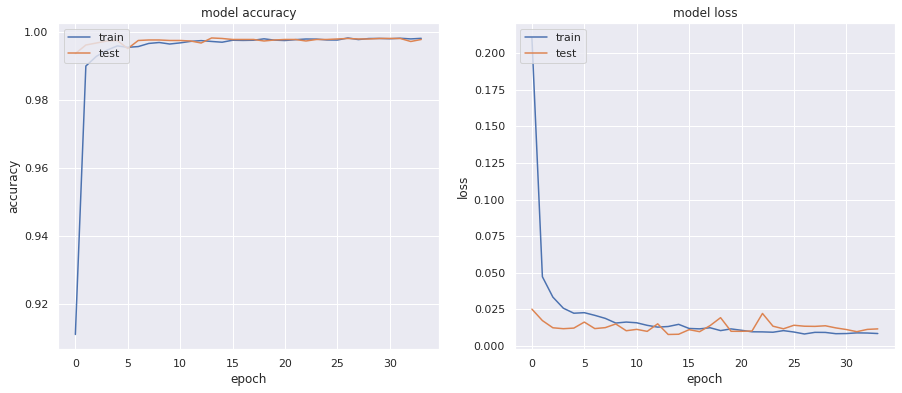

In [75]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod.history['loss'])
ax[1].plot(mod.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing3.png')

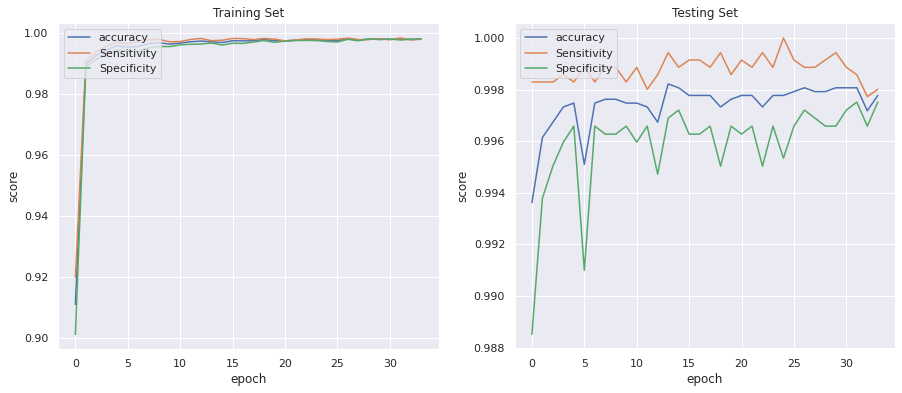

In [76]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod.history['val_accuracy'])
ax[1].plot(mod.history['val_Sensitivity'])
ax[1].plot(mod.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['Sensitivity'])
ax[0].plot(mod.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing4.png')

Model evaluation  on the testing set

In [77]:
mod2=model2.evaluate(test)[1:6]
mod2=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod2]})
mod2

106/106 [==============================] - 7s 70ms/step - loss: 0.0115 - accuracy: 0.9978 - Sensitivity: 0.9980 - Specificity: 0.9975 - Precision: 0.9977 - f1_score: 0.9978


,Measure,Original Dataset
0,Accuracy,0.9978
1,Sensitivity,0.9980
2,Specificty,0.9975
3,Precision,0.9977
4,F1 score,0.9978


Feature extraction from the text data. The features act as the variables on the prediction model.

In [78]:
feature_miner=Model(
    inputs=model2.inputs,
    outputs=model2.get_layer(name="Bidirectional2").output,name="feature_miner"
)
predictors=feature_miner.predict(train)

Kmeans clustering

In [79]:
predictors=feature_miner.predict(train)
kmea=KMeans(n_clusters=2, random_state=0).fit(predictors)
tests=feature_miner.predict(test)
kmea.labels_

array([0, 1, 1, ..., 1, 0, 0], dtype=int32)

In [80]:
with open("predictors2.pkl","wb") as file:
    pickle.dump(predictors,file)
    
with open("tests2.pkl","wb") as file:
    pickle.dump(tests,file)
    
with open("kmea2.pkl","wb") as file:
    pickle.dump(kmea,file)

In [81]:
kmeans_pred=kmea.predict(tests)
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

An important thing to notice is,the Kmeans labels 0,1 represent clusters 0 and 1 but not the data labels 0,1. the code here tries to determine which category exacltly matches which cluster.

In [82]:
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.9976243504083148
0.0023756495916852265


In [83]:
kmeans_pred1=kmeans_pred
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

Evaluating Kmeans

In [84]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             'Kmeans':[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})

,Measure,Kmeans
0,Accuracy,0.997624
1,Sensitivity,0.997440
2,Specitivity,0.997826
3,Precision,0.998007
4,F1 score,0.997723


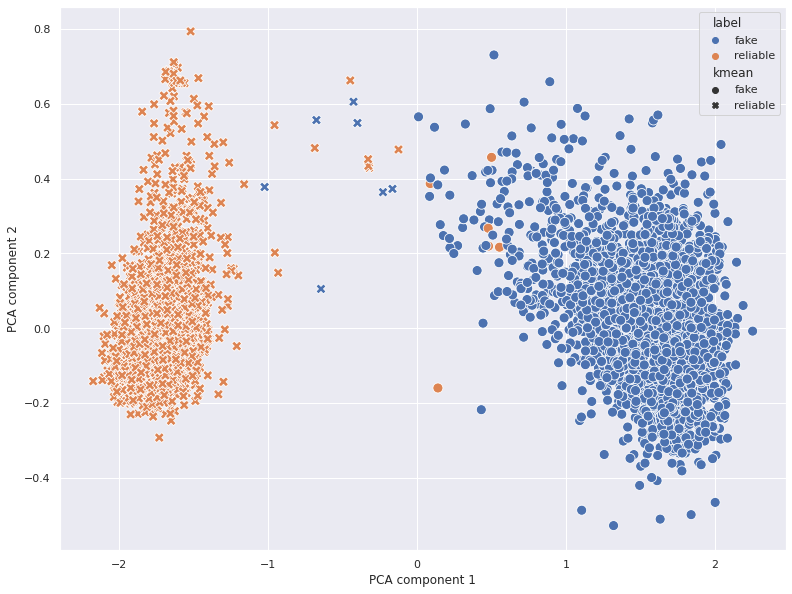

In [85]:
pca = PCA(2)
pcas= pd.DataFrame(pca.fit_transform(tests), columns = ['x','y'])
pcas['kmean']= kmeans_pred
pcas['label']= label_test

def to_binary_labels(labels):
    if labels ==0:
        x="fake"
    else:
        x= "reliable" 
    return x

pcas['label']=pd.Series (list(map(to_binary_labels,pcas['label'])))
pcas['kmean']=pd.Series (list(map(to_binary_labels,pcas['kmean'])))
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.scatterplot(data=pcas, x="x", y="y",s=100,style="kmean",hue='label')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.savefig('PCA2.png')

Next was to weight between the predictions of clustering and those from model prediction. Here a user defined function was used, which compares sensitivity from the clustering predictions and those that of from the ANN. the the model with higher sensitivity will be used to predict the the fake news class. conversely the model with higher specificity predicts the other category.

In [86]:
modelpred=np.argmax(model2.predict(test), axis=1)
sensdeep=metrics.recall_score(label_test, modelpred,pos_label=0)
senskmeans=metrics.recall_score(label_test,kmeans_pred,pos_label=0)
specdeep=metrics.recall_score(label_test, modelpred,pos_label=1)
speckmean=metrics.recall_score(label_test,kmeans_pred,pos_label=1)
def weighting(kmeans_pred,modelpred):
    conditionals= [] 
    unconditionals=[]
    types= [] 
    for i in range(len(kmeans_pred)):
        if modelpred[i]==0 and kmeans_pred[i]==0:
            x=[sensdeep*senskmeans,(1-specdeep)*(1-speckmean)]
        elif modelpred[i]==1 and kmeans_pred[i]==1:
            x=[(1-sensdeep)*(1-senskmeans),specdeep*speckmean]
        elif modelpred[i]==0 and kmeans_pred[i]==1:
            x=[sensdeep*(1-senskmeans),(1-specdeep)*speckmean]
        else:
            x=[(1-sensdeep)*senskmeans,specdeep*(1-speckmean)]
        conditionals.append(x)
        unconditionals.append((np.array(x)/sum(x)).tolist())
    preds=np.argmax(unconditionals,axis=1)
    return preds
preds=weighting(modelpred,kmeans_pred)

In [87]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.997624
1,Sensitivity,0.997440
2,Specitivity,0.997826
3,Precision,0.998007
4,F1 score,0.997723


**Validation**

In [88]:
modelpred=np.argmax(model2.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

preds=weighting(modelpred,kmeans_pred)

In [89]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.999109
1,Sensitivity,1.000000
2,Specitivity,0.998174
3,Precision,0.998264
4,F1 score,0.999131


# 3)  Liar Dataset

Liar dataset, is available benchmark dataset which has commonly been used to bench mark most fake news detection. It consists 12,800 manually labeled articles from politifact.com (Wang, 2017). The labels are in a 4-Likert scale of between true, mostly true, half-true, barely-true, and false, that is, numerical represented between a zero and four. The data is well balanced and provides a glimpse of model ability to learn from balanced datasets.

The data isnt available on kaggle we had to download it from the url https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [90]:
url = 'https://www.cs.ucsb.edu/~william/data/liar_dataset.zip'   # the url
wget.download(url, '/.')                                         #  download the zipped data to the working directory
with zipfile.ZipFile('/./liar_dataset.zip', 'r') as zip_ref:     # Extracting the files from zip
    zip_ref.extractall('/.')

The data is already split into training testing and validation set. here we load each file and combine them in to a single dataframe for easy cleaning and processing

In [91]:
Bench3_1 = pd.read_csv("/train.tsv", sep="\t",header=None)                    # read train data
Bench3_1=Bench3_1.iloc[:, 0:4].set_axis(["Id","label","text","title"],axis=1) # change column names
Bench3_1['data']='train'                                                      # add a column called data which can be used to index the data later
Bench3_2 = pd.read_csv("/test.tsv", sep="\t",header=None)                      # read test data
Bench3_2=Bench3_2.iloc[:, 0:4].set_axis(["Id","label","text","title"],axis=1)  # change column names
Bench3_2['data']='test'                                                       # add a column called data which can be used to index the data later
Bench3_3 = pd.read_csv("/valid.tsv", sep="\t",header=None)                      # read validation  data
Bench3_3=Bench3_3.iloc[:, 0:4].set_axis(["Id","label","text","title"],axis=1)  # change column names
Bench3_3['data']='valid'                                                       # add a column called data which can be used to index the data later
Bench3=pd.concat([Bench3_1, Bench3_2,Bench3_3], axis = 0,ignore_index=True)    # combine all the 3 datasets into one dataframe
#Bench3=Bench3.sample(n=2000)                 # sample small sample
Bench3['Index']=range(0,Bench3.shape[0])     # rearrange the indices after sampling 
Bench3=Bench3.set_index('Index')

For this data, the defined labels are `half-true`,`mostly-true`,`true`,`barely-true`... the function below converts these into binary labels fake or reliable

In [92]:
def to_binary_labels1(labels):
    if labels in ["half-true","mostly-true","true","barely-true"]:
        x="reliable"
    else:
        x="fake" 
    return x

Bench3['label']=pd.Series (list(map(to_binary_labels1,Bench3['label'])))

Graphing to see the distribution of articles across the two label categories.

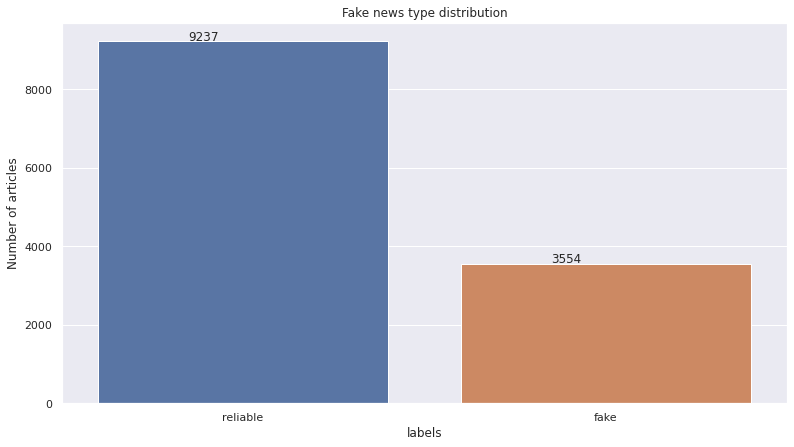

In [93]:
figure,ax=plt.subplots(nrows=1,ncols=1,figsize=(13,7))
sns.countplot(x='label',data=Bench3,ax=ax,order=Bench3.groupby('label').size().sort_values().index[::-1])
for p, label in zip(ax.patches, Bench3['label'].value_counts().index):
    ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax.set_xlabel("labels")
    ax.set_ylabel("Number of articles")
    ax.set_title('Fake news type distribution')
plt.savefig('liardatadist.png')

The titles and the article body are in different columns, here we create a new column which combines articles with their titles

In [94]:
text1=[]
for i in range(Bench3.shape[0]):
    if pd.isnull(Bench3['title'][i]) or pd.isna(Bench3['title'][i]):
        if pd.isnull(Bench3['text'][i]) or pd.isna(Bench3['text'][i]):
            x=""
        else:
            x=str(Bench3['text'][i])
    else: 
        if pd.isnull(Bench3['text'][i]) or pd.isna(Bench3['text'][i]):
            x=str(Bench3['title'][i])
        else:
            x=str(Bench3['title'][i])+"\n"+str(Bench3['text'][i])
    text1.append(x)
Bench3['text1']=pd.Series (text1)

Next emojis and emocations were removed from the articles

In [95]:
Bench3['text1']=Bench3['text1'].apply(remove_emoji)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


The next cells search for unicode characters and replace them to avoid strange codes when analyzing the data.

In [96]:
text1=[]
for j in range(Bench3.shape[0]):
    text1.append(Bench3["text1"][j].replace("’","'"))
Bench3["text1"]=pd.Series (text1)

In [97]:
for j in range(Bench3.shape[0]):
    for i in [x for x in range(s_n) if x != 2]:
        Bench3["text1"][j]=Bench3["text1"][j].replace(strange["Char"][i],str(strange["Mapped String"][i]))

Next the labels were converted into two class dummy variables because neural networks won't allow character strings.This means because we have two classes, in this order fake,reliable. label [1 0] would mean fake while [0 1] would mean reliable. Here is a example using the first row.

In [98]:
Bench3['article']=Bench3['text1'].apply(my_clean)
texts=Bench3['article'].apply(my_clean1)

In [99]:
leb=pd.get_dummies(Bench3['label']).values
print(leb[0],Bench3['label'][0])
print(leb[1],Bench3['label'][1])

[1 0] fake
[0 1] reliable


The data downloaded had already been split into `train`, `test`,`Valid` so we here we subset each from the data we have subset.

In [100]:
train=Bench3[Bench3['data']=='train'] #subset train
test=Bench3[Bench3['data']=='test']   # subset test
valid=Bench3[Bench3['data']=='valid'] # subset valid

In [101]:
print("---------training breakdown-----------")
print()
print(train.label.value_counts())
print()
print("---------testing breakdown-----------")
print()
print(test.label.value_counts())
print()
print("---------validation breakdown-------")
print(valid.label.value_counts())

---------training breakdown-----------

reliable    7406
fake        2834
Name: label, dtype: int64

---------testing breakdown-----------

reliable    926
fake        341
Name: label, dtype: int64

---------validation breakdown-------
reliable    905
fake        379
Name: label, dtype: int64


converting the data into tensorflow dataset to take advantage of these features.

In [102]:
train = tf.data.Dataset.from_tensor_slices((list(train["article"]),list(leb[Bench3['data']=='train'])))
test = tf.data.Dataset.from_tensor_slices((list(test["article"]),list(leb[Bench3['data']=='test'])))
valid = tf.data.Dataset.from_tensor_slices((list(valid["article"]),list(leb[Bench3['data']=='valid'])))

In [103]:
train= train.batch(batch_size=batch_size)
test= test.batch(batch_size=batch_size)
valid= valid.batch(batch_size=batch_size)

In [104]:
tf.data.experimental.save(train, "liartrain")
tf.data.experimental.save(test, "liartest")
tf.data.experimental.save(valid, "liarvalid")

In [105]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)

In [106]:
def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Still using our text vectorization function defined at the beggining of this code, we vectorized the first article and took a look on it.

In [107]:
article,label= next(iter(train))
sample_article,sample_label = article[0],label[0]
print("Article:")
print(sample_article)
lb=["Reliable","Fake"]
print("Label:")
print(sample_label)
print("After vectorization:")
print(vectorize_articles(sample_article,sample_label))

Article:
tf.Tensor(b'abortion\nsays the annies list political group supports third-trimester abortions on demand.', shape=(), dtype=string)
Label:
tf.Tensor([1 0], shape=(2,), dtype=uint8)
After vectorization:
(<tf.Tensor: shape=(1, 12), dtype=int64, numpy=
array([[  139,     8,     2, 16140,  1172,   533,   622,   380,  5777,
          587,    12,  1708]])>, <tf.Tensor: shape=(2,), dtype=uint8, numpy=array([1, 0], dtype=uint8)>)


2022-12-03 11:40:16.108456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [108]:
vocabularies = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabularies, range(len(vocabularies))))

Here we did more configuration practices for our data. these include, caching and prefetching

In [109]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)

In [110]:
embedding_dim=100
hits = 0
misses = 0

# Prepare embedding matrix
embed_mat = np.zeros((max_tokens + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embed_mat[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11641 words (5507 misses)


Here the model layers were specified. this is just like on the original model.See explanation of the different on the links at the begging.

In [111]:
model3=Sequential(name="my_model")
model3.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model3.add(Embedding(max_tokens + 1,
                    embedding_dim,embeddings_initializer=keras.initializers.Constant(embed_mat),
                    trainable=False,
                    name="embeddinglayer"))
model3.add(Dropout(0.2,name="dropout"))
model3.add(layers.Conv1D(8,5, activation='relu'))
model3.add(Dropout(0.2,name="dropout1"))
model3.add(BatchNormalization(name="batchnormalization"))
model3.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model3.add(Dropout(0.2,name="dropout2"))
model3.add(Dense(units=8,activation="relu"))
model3.add(Dropout(0.2,name="dropout3"))
model3.add(Dense(units=2, activation="softmax"))

Compile the model with the metrics Accuracy,sensitivity,specificity, and precision. also categorical cross entropy loss function.

In [112]:
model3.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

fit the model

In [113]:
mod=model3.fit(
 train,
  validation_data=test,
 epochs=epoch,
    callbacks=[es_callback,tensorboard_callback])

Epoch 1/200
  1/160 [..............................] - ETA: 8:19 - loss: 0.6706 - accuracy: 0.6719 - Sensitivity: 0.1667 - Specificity: 0.8696 - Precision: 0.3333 - f1_score: 0.6719

2022-12-03 11:40:56.092719: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 11:40:56.092764: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/160 [..............................] - ETA: 1:07 - loss: 0.6673 - accuracy: 0.6406 - Sensitivity: 0.1143 - Specificity: 0.8387 - Precision: 0.2105 - f1_score: 0.6406

2022-12-03 11:40:56.632078: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 11:40:56.633504: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 11:40:56.785526: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 851 callback api events and 811 activity events. 
2022-12-03 11:40:56.803021: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 11:40:56.825820: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_11_40_56



  9/160 [>.............................] - ETA: 19s - loss: 0.6428 - accuracy: 0.6962 - Sensitivity: 0.0600 - Specificity: 0.9202 - Precision: 0.2093 - f1_score: 0.6962

2022-12-03 11:40:56.842440: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_12_03_11_40_56/c01b5821b708.trace.json.gz
2022-12-03 11:40:56.867839: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_11_40_56

2022-12-03 11:40:56.873298: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_12_03_11_40_56/c01b5821b708.memory_profile.json.gz
2022-12-03 11:40:56.874699: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2022_12_03_11_40_56
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2022_12_03_11_40_56/c01b5821b708.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2022_12_03_11_40_56/c01b5821b708.overview_page.pb
Dumped tool data for i

160/160 [==============================] - 7s 27ms/step - loss: 0.6051 - accuracy: 0.7195 - Sensitivity: 0.0060 - Specificity: 0.9926 - Precision: 0.2361 - f1_score: 0.7195 - val_loss: 0.5869 - val_accuracy: 0.7309 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00 - val_f1_score: 0.7309
Epoch 2/200
160/160 [==============================] - 2s 11ms/step - loss: 0.5916 - accuracy: 0.7232 - Sensitivity: 0.0000e+00 - Specificity: 1.0000 - Precision: 0.0000e+00 - f1_score: 0.7232 - val_loss: 0.5752 - val_accuracy: 0.7309 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00 - val_f1_score: 0.7309
Epoch 3/200
160/160 [==============================] - 2s 11ms/step - loss: 0.5855 - accuracy: 0.7232 - Sensitivity: 0.0000e+00 - Specificity: 1.0000 - Precision: 0.0000e+00 - f1_score: 0.7232 - val_loss: 0.5701 - val_accuracy: 0.7309 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00 - val_f1_score: 0

In [114]:
model3.save("model3") 
with open("mod3_hist.pkl","wb") as file:
    pickle.dump(mod.history,file)

graphing the model fitting history. It helps detect overfitting. when the line for the testing is far below training it indicates that the model might be overfiting.

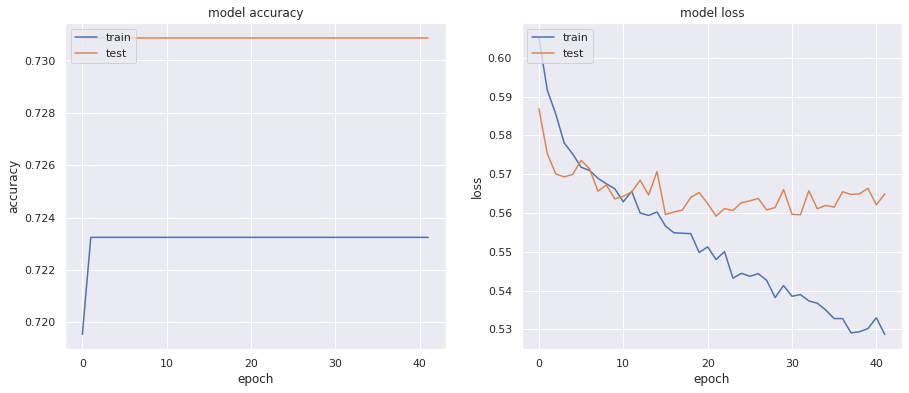

In [115]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod.history['loss'])
ax[1].plot(mod.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing5.png')

Evaluating the model

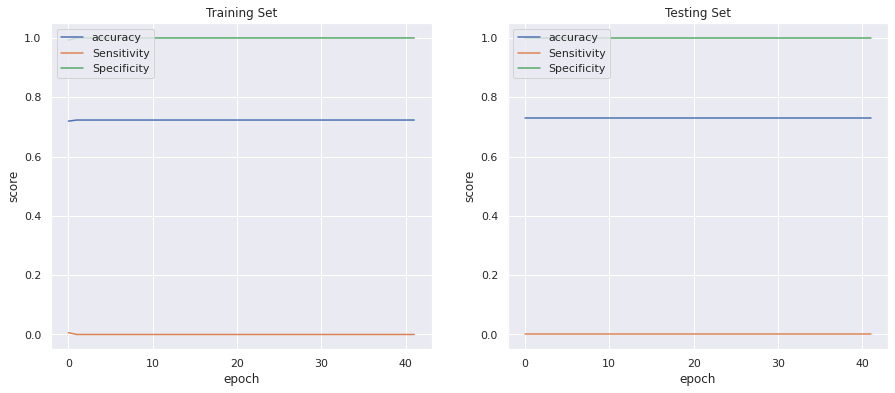

In [116]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod.history['val_accuracy'])
ax[1].plot(mod.history['val_Sensitivity'])
ax[1].plot(mod.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['Sensitivity'])
ax[0].plot(mod.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing6.png')

In [117]:
mod3=model3.evaluate(test)[1:6]
mod3=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod3]})
mod3

20/20 [==============================] - 0s 7ms/step - loss: 0.5649 - accuracy: 0.7309 - Sensitivity: 0.0000e+00 - Specificity: 1.0000 - Precision: 0.0000e+00 - f1_score: 0.7309


,Measure,Original Dataset
0,Accuracy,0.7309
1,Sensitivity,0.0000
2,Specificty,1.0000
3,Precision,0.0000
4,F1 score,0.7309


Extracting features to use in clustering

In [118]:
feature_miner=Model(
    inputs=model3.inputs,
    outputs=model3.get_layer(name="Bidirectional2").output,name="feature_miner"
)
predictors=feature_miner.predict(train)

Fitting Kmeans clustering

In [119]:
predictors=feature_miner.predict(train)                   # extract features from training articles
tests=feature_miner.predict(test)                         # extract features from testing articles 
kmea=KMeans(n_clusters=2, random_state=0).fit(predictors) # clustering 
kmea.labels_

array([0, 0, 1, ..., 0, 0, 1], dtype=int32)

In [120]:
with open("predictors3.pkl","wb") as file:
    pickle.dump(predictors,file)
    
with open("tests3.pkl","wb") as file:
    pickle.dump(tests,file)
    
with open("kmea3.pkl","wb") as file:
    pickle.dump(kmea,file)

In [121]:
kmeans_pred=kmea.predict(tests)
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [122]:
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.5966850828729282
0.40331491712707185


An important thing to notice is,the Kmeans labels 0,1 represent clusters 0 and 1 but not the data labels 0,1. the code here tries to determine which category exacltly matches which cluster.

In [123]:
kmeans_pred1=kmeans_pred
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [124]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'Kmeans':[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})

,Measure,Kmeans
0,Accuracy,0.596685
1,Sensitivity,0.656891
2,Specitivity,0.574514
3,Precision,0.362460
4,F1_score,0.467153


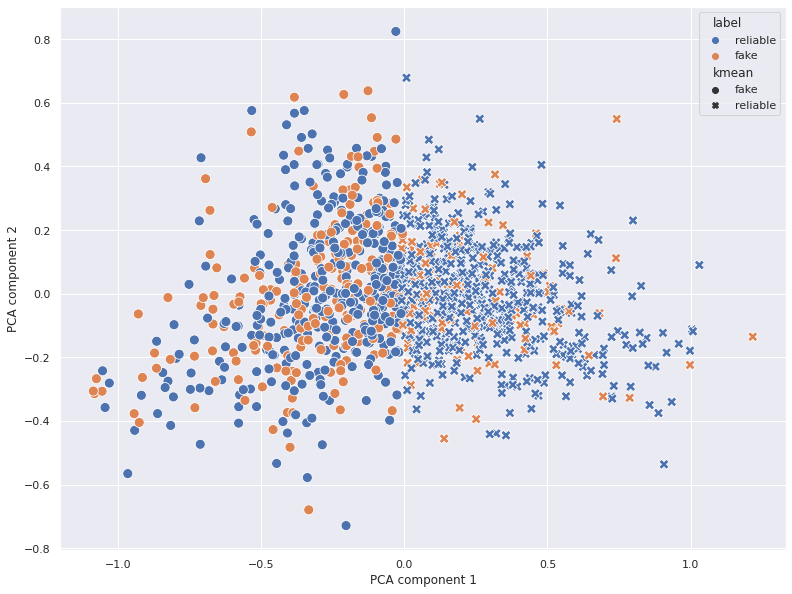

In [125]:
pca = PCA(2)
pcas= pd.DataFrame(pca.fit_transform(tests), columns = ['x','y'])
pcas['kmean']= kmeans_pred
pcas['label']= label_test

def to_binary_labels(labels):
    if labels ==0:
        x="fake"
    else:
        x= "reliable" 
    return x

pcas['label']=pd.Series (list(map(to_binary_labels,pcas['label'])))
pcas['kmean']=pd.Series (list(map(to_binary_labels,pcas['kmean'])))
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.scatterplot(data=pcas, x="x", y="y",s=100,style="kmean",hue='label')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.savefig('PCA3.png')

Next was to weight between the predictions of clustering and those from model prediction. Here a user defined function was used, which compares sensitivity from the clustering predictions and those that of from the ANN. the the model with higher sensitivity will be used to predict the the fake news class. conversely the model with higher specificity predicts the other category.

In [126]:
modelpred=np.argmax(model3.predict(test), axis=1)
sensdeep=metrics.recall_score(label_test, modelpred,pos_label=0)
senskmeans=metrics.recall_score(label_test,kmeans_pred,pos_label=0)
specdeep=metrics.recall_score(label_test, modelpred,pos_label=1)
speckmean=metrics.recall_score(label_test,kmeans_pred,pos_label=1)
def weighting(kmeans_pred,modelpred):
    conditionals= [] 
    unconditionals=[]
    types= [] 
    for i in range(len(kmeans_pred)):
        if modelpred[i]==0 and kmeans_pred[i]==0:
            x=[sensdeep*senskmeans,(1-specdeep)*(1-speckmean)]
        elif modelpred[i]==1 and kmeans_pred[i]==1:
            x=[(1-sensdeep)*(1-senskmeans),specdeep*speckmean]
        elif modelpred[i]==0 and kmeans_pred[i]==1:
            x=[sensdeep*(1-senskmeans),(1-specdeep)*speckmean]
        else:
            x=[(1-sensdeep)*senskmeans,specdeep*(1-speckmean)]
        conditionals.append(x)
        unconditionals.append((np.array(x)/sum(x)).tolist())
    preds=np.argmax(unconditionals,axis=1)
    return preds
preds=weighting(modelpred,kmeans_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [127]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Weighted":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Weighted
0,Accuracy,0.596685
1,Sensitivity,0.656891
2,Specitivity,0.574514
3,Precision,0.362460
4,F1_score,0.467153


**Validation**

In [128]:
modelpred=np.argmax(model3.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

preds=weighting(modelpred,kmeans_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [129]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "weighted":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})

,Measure,weighted
0,Accuracy,0.594237
1,Sensitivity,0.643799
2,Specitivity,0.573481
3,Precision,0.387302
4,F1_score,0.483647
